In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Calibration Data

In [2]:
total_miles = pd.read_excel(
    'https://www.fhwa.dot.gov/policyinformation/statistics/2014/xls/vm202.xls',
    skiprows=9, skip_footer=1, header=None, usecols=[0, 17], names=['year', 'miles']
).set_index(['year'])['miles'] * 1e6

In [3]:
# Source: http://www-fars.nhtsa.dot.gov/Trends/TrendsGeneral.aspx, Copied 18 October 2016
# Units are per 100 million miles
fatalities = pd.Series(
    [1.73, 1.73, 1.69, 1.65, 1.58,
     1.55, 1.53, 1.51, 1.51, 1.48,
     1.44, 1.46, 1.42, 1.36, 1.26,
     1.15, 1.11, 1.10, 1.14, 1.10,
     1.08], index = range(1994, 2015))

# Parameters

In [15]:
start_year = 2017
miles_growth_rate = total_miles.pct_change().rolling(10).mean().iloc[-1]
fatalities_per_mile = fatalities.rolling(5).mean().iloc[-1] / 1e8
initial_fatalities_per_autonomous_mile = fatalities_per_mile / 2
final_fatalities_per_autonomous_mile = fatalities_per_mile / 10
displacement_rate = 1.5 # Autonomous miles added per non-autonomous mile displaced
estimated_transition_years = 30 # Guess on how many years to 
max_crowdout = .95 # Maximum percent of non-autonomous miles that will be displaced
slowing_factor = .99 # Constant defining how much slower regulation makes the process.
k = .25 # steepness of adoption 

# Calculations

In [16]:
years_to_midpoint = estimated_transition_years / 2
end_year = int(start_year + estimated_transition_years / slowing_factor)
slow_k = k * slowing_factor
slow_years_to_midpoint = years_to_midpoint / slowing_factor

In [17]:
df = pd.DataFrame({'year': list(range(start_year, end_year + 1))})
df['baseline_miles'] = total_miles.iloc[-1]  * (1 + miles_growth_rate) ** (df['year'] - total_miles.index[-1])
df['fatalities_per_autonomous_mile'] = fatalities_per_mile * (.5 - (.4  / (1 + np.exp(-k * (df['year'] - df['year'].iloc[0] - years_to_midpoint)))))
df['displacement'] = max_crowdout / (1 + np.exp(-k * (df['year'] - df['year'].iloc[0] - years_to_midpoint)))
df['non_autonomous_miles'] = df['baseline_miles'] * (1 - df['displacement'])
df['autonomous_miles'] = df['baseline_miles'] * (displacement_rate * df['displacement'])
df['non_autonomous_fatalities'] = df['non_autonomous_miles'] * fatalities_per_mile
df['autonomous_fatalities'] = df['autonomous_miles'] * df['fatalities_per_autonomous_mile']
df['total_fatalities'] = df['non_autonomous_fatalities'] + df['autonomous_fatalities']

In [18]:
df['displacement_regulated'] = max_crowdout / (1 + np.exp(-slow_k * (df['year'] - df['year'].iloc[0] - slow_years_to_midpoint)))
df['non_autonomous_miles_regulated'] = df['baseline_miles'] * (1 - df['displacement_regulated'])
df['autonomous_miles_regulated'] = df['baseline_miles'] * (displacement_rate * df['displacement_regulated'])
df['non_autonomous_fatalities_regulated'] = df['non_autonomous_miles_regulated'] * fatalities_per_mile
df['autonomous_fatalities_regulated'] = df['autonomous_miles_regulated'] * df['fatalities_per_autonomous_mile']
df['total_fatalities_regulated'] = df['non_autonomous_fatalities_regulated'] + df['autonomous_fatalities_regulated']

# Results

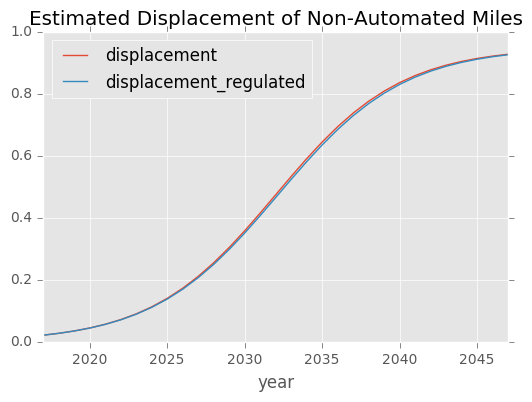

In [19]:
fig, ax = plt.subplots()
df.set_index('year')[['displacement', 'displacement_regulated']].plot(ax=ax)
ax.set_title("Estimated Displacement of Non-Automated Miles")
ax.set_ybound(0, 1)

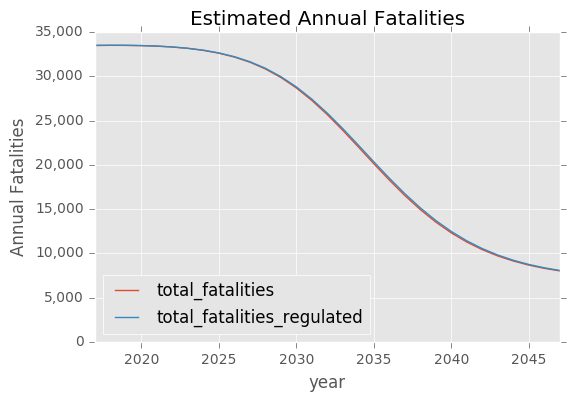

In [20]:
fig, ax = plt.subplots()
df.set_index('year')[['total_fatalities', 'total_fatalities_regulated']].plot(ax=ax)
ax.set_title("Estimated Annual Fatalities")
ax.set_ybound(0)
ax.set_yticklabels('{:,.0f}'.format(i) for i in ax.get_yticks())
ax.set_ylabel("Annual Fatalities")

In [21]:
print('Using the above assumptions, the model projects an additional '
      '{:,.0f} fatalities due to the regulatory slowing of adoption'
      .format((df['total_fatalities_regulated'] - df['total_fatalities']).sum())
)

Using the above assumptions, the model projects an additional 2,989 fatalities due to the regulatory slowing of adoption


In [22]:
df.to_csv('results.csv')

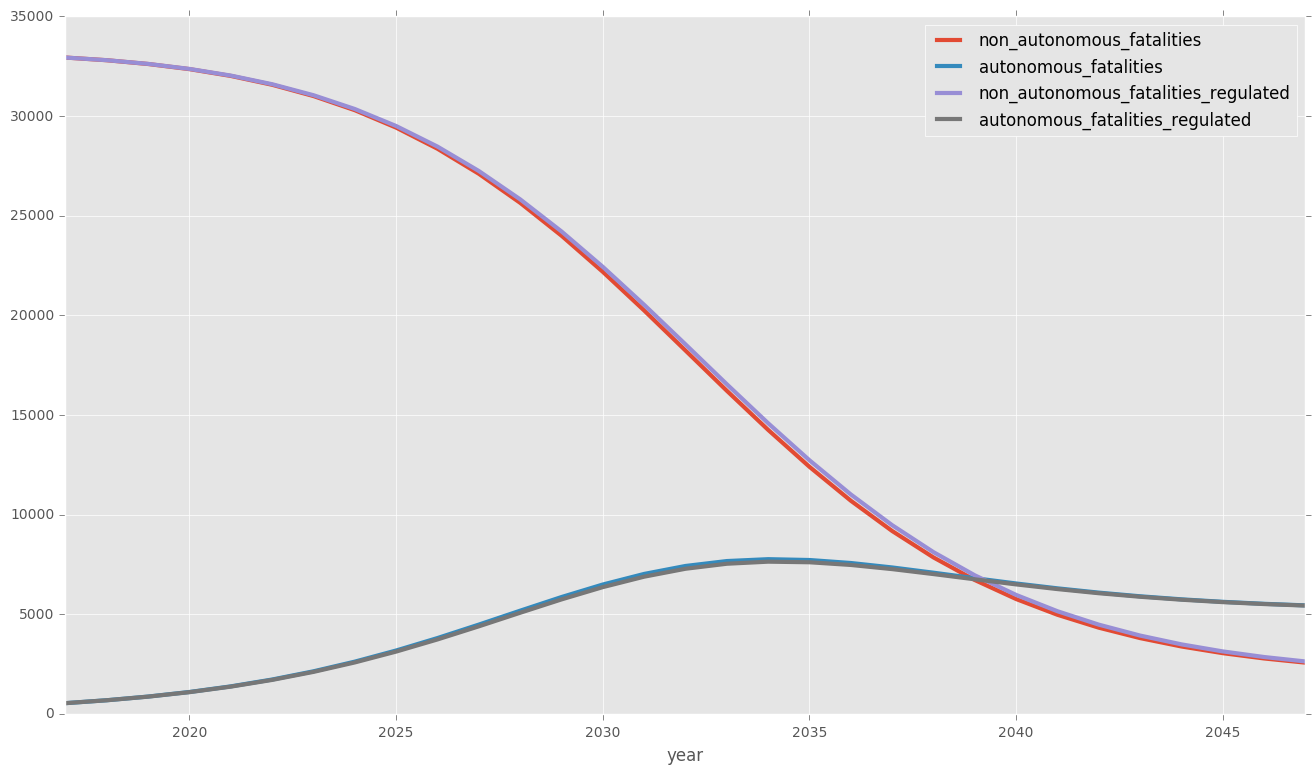

In [23]:
(df.set_index('year')
 [['non_autonomous_fatalities', 'autonomous_fatalities', 'non_autonomous_fatalities_regulated', 'autonomous_fatalities_regulated']]
 .plot(figsize=(16, 9), linewidth=3)
 )

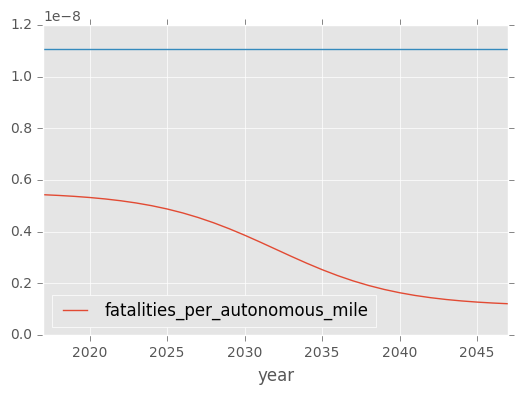

In [24]:
df.set_index('year')[['fatalities_per_autonomous_mile']].plot()
plt.gca().plot(df.year.values, [fatalities_per_mile] * len(df.year), label='fatalities_per_mile')

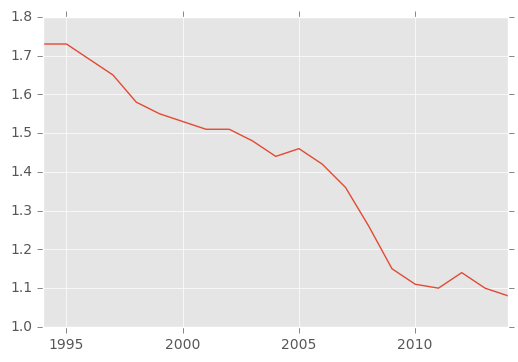

In [25]:
fatalities.plot()